## Project - 모델 성능 개선

- **전처리나 형태소 분석기를 바꾸어 보기**
- **다른 날짜의 훈련 데이터를 일부 추가해 모델을 일반화**

**크롤러를 만들기 전 필요한 도구들을 임포트**

In [171]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm

**데이터 합치기**

In [149]:
import pandas as pd
import glob
import os

input_file = '/home/aiffel0042/aiffel/news_crawler' # csv파일들이 있는 디렉토리 위치
output_file = '/home/aiffel0042/aiffel/news_crawler/news_data3.csv' # 병합하고 저장하려는 파일명

allFile_list = glob.glob(os.path.join(input_file, 'news_*')) # glob함수로 sales_로 시작하는 파일들을 모은다
print(allFile_list)
allData = [] # 읽어 들인 csv파일 내용을 저장할 빈 리스트를 하나 만든다
for file in allFile_list:
    df = pd.read_csv(file) # for구문으로 csv파일들을 읽어 들인다
    allData.append(df) # 빈 리스트에 읽어 들인 내용을 추가한다

dataCombine = pd.concat(allData, axis=0, ignore_index=True) # concat함수를 이용해서 리스트의 내용을 병합
# axis=0은 수직으로 병합함. axis=1은 수평. ignore_index=True는 인데스 값이 기존 순서를 무시하고 순서대로 정렬되도록 한다.
dataCombine.to_csv(output_file, index=False) # to_csv함수로 저장한다. 인데스를 빼려면 False로 설정


['/home/aiffel0042/aiffel/news_crawler/news_data.csv', '/home/aiffel0042/aiffel/news_crawler/news_data3.csv', '/home/aiffel0042/aiffel/news_crawler/news_data2.csv']


## 1. 데이터 전처리

**데이터 정제(불러오기)**

In [150]:
csv_path = os.getenv("HOME") + "/aiffel/news_crawler/news_data3.csv"
df = pd.read_table(csv_path, sep=',')
df.head()

,news,code
0,파주시청. 사진제공=파주시 파주시청. 사진제공=파주시\n\n[파주=파이낸셜뉴스 강근...,사회
1,동영상 뉴스\n\n이천 물류창고 화재 발화지점으로 지목된 지하 2층에서 산소절단기의...,사회
2,황범순 의정부시 부시장 을지대학교 의정부캠퍼스 및 부속병원 공사현장 안전점검. 사진...,사회
3,귀갓길 여성을 쫓아가 성범죄를 시도한 20대 남성이 구속됐습니다.서울 강남경찰서는 ...,사회
4,(서울=연합뉴스) 대한약사회가 6일부터 코로나바이러스 감염증 대응 체계를 '사회적 ...,사회


**정규 표현식을 이용해서 한글 외의 문자는 전부 제거**

In [151]:
df['news'] = df['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df['news']

0        파주시청 사진제공파주시 파주시청 사진제공파주시파주파이낸셜뉴스 강근주 기자 파주시는 ...
1        동영상 뉴스이천 물류창고 화재 발화지점으로 지목된 지하 층에서 산소절단기의 산소 공...
2        황범순 의정부시 부시장 을지대학교 의정부캠퍼스 및 부속병원 공사현장 안전점검 사진제...
3        귀갓길 여성을 쫓아가 성범죄를 시도한 대 남성이 구속됐습니다서울 강남경찰서는 강간상...
4        서울연합뉴스 대한약사회가 일부터 코로나바이러스 감염증 대응 체계를 사회적 거리두기에...
                               ...                        
59182    레고켐바이오사이언스대표 김용주사진가 글로벌 기술수출에 또다시 성공했다 년 중국 포순...
59183    제대 국회의원선거 기간 중단됐던 네이버 실시간 급상승 검색어 서비스가 일 오후 시부...
59184    아마존 연합뉴스 자료사진 아마존 연합뉴스 자료사진직원들 코로나 확산 방지 조치 충분...
59185    제대 국회의원선거가 임박한 가운데 투표 및 개표 방송을 준비하는 기업들의 움직임이 ...
59186    롤 점검이 일 진행될 예정이다온라인게임 리그오브레전드이하 롤은 일 오전 시부터 오전...
Name: news, Length: 59187, dtype: object

In [152]:
print(df.isnull().sum())

news    0
code    0
dtype: int64


- 데이터에 Null 값이 있지는 않은지 확인
- 중복 샘플 여부 확인(네이버 뉴스에는 많은 뉴스가 중복으로 수집되고 있음)
- df.sample() 의 출력 결과에서 중복인 기사들을 확인 가능
- 하지만 더 간단히는 중복을 제거한 데이터 수를 확인하고, 우리가 수집한 데이터의 개수와 - 비교하여 데이터에 중복이 있는지 확인할 수 있음

**현재 뉴스 기사의 개수(중복 포함) / 뉴스 데이터 1 & 2 합쳤음**

In [154]:
print('뉴스 기사의 개수: ',len(df))

뉴스 기사의 개수:  59187


**중복된 샘플들을 제거합니다.**

In [155]:
df.drop_duplicates(subset=['news'], inplace=True)

print('뉴스 기사의 개수: ',len(df))

뉴스 기사의 개수:  6127


## 2. 데이터 탐색

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54924 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54876 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47928 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home

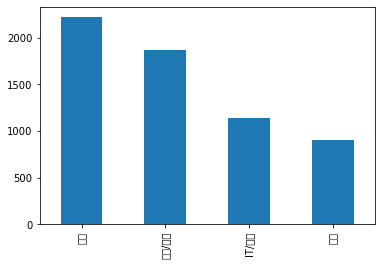

In [156]:
df['code'].value_counts().plot(kind = 'bar')

In [157]:
print(df.groupby('code').size().reset_index(name = 'count'))

    code  count
0  IT/과학   1141
1     경제    901
2     사회   2218
3  생활/문화   1867


**토큰화 // 형태소 분석기 변경해보기(5개 비교)** 

In [158]:
#토큰화 할 시, 에러가 나올 경우
#java, jdk를 다운받고 실행하면 에러가 사라집니다.

#How To Install Java with Apt on Ubuntu 18.04
#https://www.digitalocean.com/community/tutorials/how-to-install-java-with-apt-on-ubuntu-18-04

In [159]:
from konlpy.tag import Mecab
tokenizer = Mecab()

kor_text = '밤에 귀가하던 여성에게 범죄를 시도한 대 남성이 구속됐다서울 제주경찰서는 \
            상해 혐의로 씨를 구속해 수사하고 있다고 일 밝혔다씨는 지난달 일 피해 여성을 \
            인근 지하철 역에서부터 따라가 폭행을 시도하려다가 도망간 혐의를 받는다피해 \
            여성이 저항하자 놀란 씨는 도망갔으며 신고를 받고 주변을 수색하던 경찰에 \
            체포됐다피해 여성은 이 과정에서 경미한 부상을 입은 것으로 전해졌다'

#- 형태소 분석, 즉 토큰화(tokenization)를 합니다.
print(tokenizer.morphs(kor_text))

['밤', '에', '귀가', '하', '던', '여성', '에게', '범죄', '를', '시도', '한', '대', '남성', '이', '구속', '됐', '다', '서울', '제주', '경찰서', '는', '상해', '혐의', '로', '씨', '를', '구속', '해', '수사', '하', '고', '있', '다고', '일', '밝혔', '다', '씨', '는', '지난달', '일', '피해', '여성', '을', '인근', '지하철', '역', '에서부터', '따라가', '폭행', '을', '시도', '하', '려다가', '도망간', '혐의', '를', '받', '는다', '피해', '여성', '이', '저항', '하', '자', '놀란', '씨', '는', '도망갔으며', '신고', '를', '받', '고', '주변', '을', '수색', '하', '던', '경찰', '에', '체포', '됐', '다', '피해', '여성', '은', '이', '과정', '에서', '경미', '한', '부상', '을', '입', '은', '것', '으로', '전해졌', '다']


In [160]:
from konlpy.tag import Okt
tokenizer = Okt()

kor_text = '밤에 귀가하던 여성에게 범죄를 시도한 대 남성이 구속됐다서울 제주경찰서는 \
            상해 혐의로 씨를 구속해 수사하고 있다고 일 밝혔다씨는 지난달 일 피해 여성을 \
            인근 지하철 역에서부터 따라가 폭행을 시도하려다가 도망간 혐의를 받는다피해 \
            여성이 저항하자 놀란 씨는 도망갔으며 신고를 받고 주변을 수색하던 경찰에 \
            체포됐다피해 여성은 이 과정에서 경미한 부상을 입은 것으로 전해졌다'

#- 형태소 분석, 즉 토큰화(tokenization)를 합니다.
print(tokenizer.morphs(kor_text))

['밤', '에', '귀가', '하던', '여성', '에게', '범죄', '를', '시도', '한', '대', '남성', '이', '구속', '됐다', '서울', '제', '주', '경찰서', '는', '상해', '혐의', '로', '씨', '를', '구속', '해', '수사', '하고', '있다고', '일', '밝혔다', '씨', '는', '지난달', '일', '피해', '여성', '을', '인근', '지하철', '역', '에서부터', '따라가', '폭행', '을', '시도', '하려다가', '도망간', '혐의', '를', '받는다', '피해', '여성', '이', '저항', '하자', '놀란', '씨', '는', '도망갔으며', '신고', '를', '받고', '주변', '을', '수색', '하던', '경찰', '에', '체포', '됐다', '피해', '여성', '은', '이', '과정', '에서', '경미한', '부상', '을', '입은', '것', '으로', '전해졌다']


In [161]:
from konlpy.tag import Hannanum
tokenizer = Hannanum()

kor_text = '밤에 귀가하던 여성에게 범죄를 시도한 대 남성이 구속됐다서울 제주경찰서는 \
            상해 혐의로 씨를 구속해 수사하고 있다고 일 밝혔다씨는 지난달 일 피해 여성을 \
            인근 지하철 역에서부터 따라가 폭행을 시도하려다가 도망간 혐의를 받는다피해 \
            여성이 저항하자 놀란 씨는 도망갔으며 신고를 받고 주변을 수색하던 경찰에 \
            체포됐다피해 여성은 이 과정에서 경미한 부상을 입은 것으로 전해졌다'

#- 형태소 분석, 즉 토큰화(tokenization)를 합니다.
print(tokenizer.morphs(kor_text))

['밤', '에', '귀가', '하', '던', '여성', '에게', '범죄', '를', '시도', '하', 'ㄴ', '대', '남성', '이', '구속됐다서울', '제주경찰', '서는', '상하', '어', '혐의', '로', '씨', '를', '구속해', '수사', '하고', '있', '다', '고', '일', '밝혔다씨', '는', '지난달', '일', '피하', '어', '여성', '을', '인근', '지하철', '역', '에서부터', '따르', '아', '가', '아', '폭행', '을', '시도', '하', '려', '다가', '도망가', 'ㄴ', '혐의', '를', '받는다피해', '여성', '이', '저항', '하', '자', '놀라', 'ㄴ', '씨', '는', '도망가', '아며', '신고', '를', '받', '고', '주변', '을', '수색', '하', '던', '경찰', '에', '체포됐다피해', '여성', '은', '이', '과정', '에서', '경미한', '부상', '을', '입', '은', '것', '으로', '전하', '어', '지', '었다']


In [162]:
from konlpy.tag import Kkma
tokenizer = Kkma()

kor_text = '밤에 귀가하던 여성에게 범죄를 시도한 대 남성이 구속됐다서울 제주경찰서는 \
            상해 혐의로 씨를 구속해 수사하고 있다고 일 밝혔다씨는 지난달 일 피해 여성을 \
            인근 지하철 역에서부터 따라가 폭행을 시도하려다가 도망간 혐의를 받는다피해 \
            여성이 저항하자 놀란 씨는 도망갔으며 신고를 받고 주변을 수색하던 경찰에 \
            체포됐다피해 여성은 이 과정에서 경미한 부상을 입은 것으로 전해졌다'

#- 형태소 분석, 즉 토큰화(tokenization)를 합니다.
print(tokenizer.morphs(kor_text))

['밤', '에', '귀가', '하', '더', 'ㄴ', '여성', '에게', '범죄', '를', '시도', '하', 'ㄴ', '대', '남성', '이', '구속', '되', '었', '다', '서울', '제주', '경찰서', '는', '상해', '혐의', '로', '씨', '를', '구속', '하', '어', '수사', '하', '고', '있', '다고', '일', '밝히', '었', '다', '씨', '는', '지난달', '일', '피해', '여성', '을', '인근', '지하철', '역', '에서', '부터', '따라가', '폭행을', '시도', '하', '려', '다그', '아', '도망가', 'ㄴ', '혐의', '를', '받', '는', '다', '피해', '여성', '이', '저항', '하', '자', '놀라', 'ㄴ', '씨', '는', '도망가', '었', '으며', '신고', '를', '받', '고', '주변', '을', '수색', '하', '더', 'ㄴ', '경찰', '에', '체포', '되', '었', '다', '피해', '여성', '은', '이', '과정', '에서', '경미', '하', 'ㄴ', '부상', '을', '입', '은', '것', '으로', '전하', '어', '지', '었', '다']


In [163]:
from konlpy.tag import Komoran
tokenizer = Komoran()

kor_text = '밤에 귀가하던 여성에게 범죄를 시도한 대 남성이 구속됐다서울 제주경찰서는 \
            상해 혐의로 씨를 구속해 수사하고 있다고 일 밝혔다씨는 지난달 일 피해 여성을 \
            인근 지하철 역에서부터 따라가 폭행을 시도하려다가 도망간 혐의를 받는다피해 \
            여성이 저항하자 놀란 씨는 도망갔으며 신고를 받고 주변을 수색하던 경찰에 \
            체포됐다피해 여성은 이 과정에서 경미한 부상을 입은 것으로 전해졌다'

#- 형태소 분석, 즉 토큰화(tokenization)를 합니다.
print(tokenizer.morphs(kor_text))

['밤', '에', '귀가', '하', '던', '여성', '에게', '범죄', '를', '시도', '하', 'ㄴ', '대', '남성', '이', '구속', '되', '었', '다', '서울', '제주', '경찰서', '는', '상해', '혐의', '로', '씨', '를', '구속', '하', '아', '수사', '하', '고', '있', '다고', '일', '밝히', '었', '다', '씨', '는', '지난달', '일', '피해', '여성', '을', '인근', '지하철', '역', '에서부터', '따라가', '아', '폭행', '을', '시도', '하', '려다가', '도망가', 'ㄴ', '혐의', '를', '받', '는다', '피하', '아', '여성', '이', '저항', '하', '자', '놀라', 'ㄴ', '씨', '는', '도망가', '았', '으며', '신고', '를', '받', '고', '주변', '을', '수색', '하', '던', '경찰', '에', '체포', '되', '었', '다', '피하', '아', '여성', '은', '이', '과정', '에서', '경미', '하', 'ㄴ', '부상', '을', '입', '은', '것', '으로', '전하', '아', '지', '었', '다']


**불용어(stopwords) 추가해 보기**

In [164]:
stopwords = ['에','는','은','을','했','에게','있','이','의','하','한',
             '다','과','때문','할','수','무단','따른','및','금지','전재',
             '경향신문','기자','는데','가','등','들','파이낸셜','저작','등',
             '뉴스', '동아일보', '매일경제', '우리', '근거하여', '의거하여', 
             '하지마', '그러나', '그런데', '아니면', '이용하여', '하지만', 
             '앞에서', '중에서', '까지', '반드시', '또한', '실로', '당',
            '언제', '누가', '어디', '무엇', '무슨', '왜']







In [165]:
len(stopwords)

55

In [172]:
# 토큰화 및 토큰화 과정에서 불용어를 제거하는 함수입니다.
def preprocessing(data):
    news_data3 = []
    
    for sentence in tqdm(data):
        temp_data = []
    #- 토큰화
        temp_data = tokenizer.morphs(sentence) 
    #- 불용어 제거
        temp_data = [word for word in temp_data if not word in stopwords] 
        news_data3.append(temp_data)

    news_data3 = list(map(' '.join, news_data3))

    return news_data3

news_data3 = preprocessing(df['news'])


**머신 러닝 사용**

In [173]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [174]:
news_data3

['파주 시청 사진 제공 파주시 파주 시청 사진 제공 파주시 파주 파이낸셜뉴스 강 근 주 파주시 일 관내 취약 계층 만 가구 대하 아 정부 긴급 재난 지원금 입금 완료 았 파주시 민이 받 긴급 재난 지원금 인 이상 가구 기준 으로 만원 받 게 되 며 인 가구 만원 인 가구 만원 인 가구 만원 이다 정부 발표 ㄴ 긴급 재난 지원금 파주시 민 지급 ㄴ 금액 다른 이유 국비 지방비 부담 비율 이다 파주시 이미 모든 시민 경기도 파주시 재난 기본소득 인당 각 만원 지급 고 어 시민 국비 지원금 만 지급 며 인 가구 기준 으로 총 지원 금액 파주시 재난 기본소득 만원 경기도 재난 기본소득 만원 정부 긴급 재난 지원금 만원 총 만원 받 게 되 ㄴ 취약 계층 아니 ㄴ 시민 오 월 일 부터 소지 고 신용 체크카드 사 홈페이지 에서 긴급 재난 지원금 지원 신청 ㄹ 세대주 가족 지원금 일괄 신청 아야 한편 파주시 일 김정기 부시장 단장 으로 긴급 재난 지원금 추진 태스크포스를 구성 아 긴급 재난 지원금 원활 게 지급 되 ㄹ 도록 지원 ㄴ다 저작권 자 파이낸셜뉴스 재 배포',
 '동영상 이천 물류 창고 화재 발화 지점 으로 지목 되 ㄴ 지하 층 에서 산소 절단기 산소 공급 호스 끊어지 ㄴ 채 발견 되 어 경찰 폭발 가능 성 수사 고 습니다 확보 ㄴ 현장 감식 사진 보 면 산소 절단 기와 연결 되 ㄴ 산소 공급 호스 날카롭 게 절단 되 어 었 습니다 전문가 산소 공급 호스 기계 적 충격 의하 아 절단 되 었 고 실제 산소 새 었 다면 폭발 일어나 ㄹ 다는 의견 제시 았 습니다 지하 층 에서 ㄴ 밖 도 전동 절단 기와 그라인더 불꽃 발생 시키 ㄹ 작업 도구 다수 나오 아 경찰 집중 분석 고 습니다 경찰 또 건물 옆 에서 우레탄 혼합 아 작업 현장 으로 보내 차량 발견 아 화재 당시 우레탄 폼 발포 작업 함께 불꽃 튀 화기 작업 동시 진행 되 었 는지 를 조사 고 습니다 당신 제보 되 ㅂ니다 여러분 소중 ㄴ 제보 를 기 립 니다 카카오톡 검색 아 채널 추가 전화 메일 온라인 제보 저작

In [175]:
#- 훈련 데이터와 테스트 데이터를 분리합니다.
X_train, X_test, y_train, y_test = train_test_split(news_data3, df['code'], random_state = 0)


In [176]:
print('훈련용 뉴스 기사의 개수 :', len(X_train))
print('테스트용 뉴스 기사의 개수 : ', len(X_test))
print('훈련용 레이블의 개수 : ', len(y_train))
print('테스트용 레이블의 개수 : ', len(y_test))

훈련용 뉴스 기사의 개수 : 4595
테스트용 뉴스 기사의 개수 :  1532
훈련용 레이블의 개수 :  4595
테스트용 레이블의 개수 :  1532


In [177]:
#- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저입니다.
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

#- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#- 나이브 베이즈 분류기를 수행합니다.
#- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [178]:
def tfidf_vectorizer(data):
    data_counts = count_vect.transform(data)
    data_tfidf = tfidf_transformer.transform(data_counts)
    return data_tfidf

In [179]:
y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       IT/과학       0.88      0.70      0.78       291
          경제       0.90      0.44      0.59       236
          사회       0.72      0.94      0.82       545
       생활/문화       0.78      0.81      0.80       460

    accuracy                           0.78      1532
   macro avg       0.82      0.72      0.75      1532
weighted avg       0.80      0.78      0.77      1532



### [정리 및 결과]

**1. 업로드 한 news_data1 과 news_data2를 합쳐서 새로운 csv파일을 생서하여 데이터의 개수를 늘림**   
**2. 중복된 기사의 내용은 제거하여 데이터를 전처리하였음**
**3. 토큰화 형태기 분석기에 따라서 결과값이 큰 영향을 받지 않음**   
**4. 경제 데이터가 901개로 제일 부족하여 f1-score값이 낮게 나왔지만, IT/과학 데이터도 많은 양은 아니지만 높은 score를 도출했음**   
**5. 경제 데이터의 수가 부족하여 낮은 예측률이 나왔음을 알 수 있음** 
<br/>
<br/>
### [대안]
**1. f1-score를 높일 수 있는 방안으로**   
**1-1. 경제 데이터를 추가해 4가지 코드의 데이터 개수를 맞춰주는 것**   
**1-2. 나이브 베이즈 분류기를 제외하고 다른 분류기 모델을 사용하여 머신 러닝 해볼 것**